# Research Extension:

## Motivation and Background
Based on the observation that generative classifiers converge to a target accuracy with a smaller set of training data while discriminative classifiers converge to a higher accuracy given a large enough training set, we sought to combine a generative and discriminative classifier to create one with the strength of both.

We know that multiple heuristics can be combined to a dominant heuristic by taking the maximum. Similarly, an ensemble of binary classifiers can combined to one with a lower error rate by taking the majority prediction. Our objective was the utilitize the conditional probability measures present in probabilistic classifiers to create a classifier with high accuracy on small datasets while converging to a high accuracy with large datasets. 



## Methods

Our naive Bayes classifier and logistic regression classifier both produce conditional probability estimates on class labels.

We trained one of each classifier:
The naive Bayes classifier was trained with continuous features to normalized to 10 bins of equal range and using Laplacian smooth.
The logistic regression classifier was trained with a lambda (overfit penalty multiplier) of 0.1.

We treated each classifier as different hypotheses with their confidence estimates as a likelihood estimation of class labels based on the classifier's hypothesis. For each sample in the test set, the prediction of the classifier with the greatest likelihood estimate was chosen as the combined classifier's prediction.

In [ ]:

import util
import numpy as np
import matplotlib.pyplot as plt
from sting.data import parse_c45
from nbayes import NaiveBayes
from combination import predict_logreg, predict_nbayes

def combined_predictions(file_base, root_dir="../440data"):
    schema, X, y = parse_c45(file_base, root_dir)
    nbayes_acc = []
    logreg_acc = []
    confidence_weighted_acc = []

    nbayes_prec = []
    logreg_prec = []
    confidence_weighted_prec = []

    nbayes_rec = []
    logreg_rec = []
    confidence_weighted_rec = []

    min_test_size = 10
    max_test_size = y.size
    step = int(y.size/50)
    for test_size in range(min_test_size, max_test_size/2, step):
        # train and generate predictions for naive bayes and logistic regression classifiers
        nbayes_predictions = predict_nbayes(schema, X, y, test_size)
        logreg_predictions = predict_logreg(schema, X, y, test_size)

        # record metrics for naive bayes and logreg
        nb_acc = util.accuracy(y, nbayes_predictions[:,0])
        nbayes_acc.append(nb_acc)
        lr_acc = util.accuracy(y, logreg_predictions[:,0])
        logreg_acc.append(lr_acc)

        nb_prec = util.precision(y, nbayes_predictions[:,0])
        nbayes_prec.append(nb_prec)
        lr_prec = util.precision(y, logreg_predictions[:,0])
        logreg_prec.append(lr_prec)

        nb_rec = util.recall(y, nbayes_predictions[:,0])
        nbayes_rec.append(nb_rec)
        lr_rec = util.recall(y, logreg_predictions[:,0])
        logreg_rec.append(lr_rec)

        # pick confidence-weighted predictions for the combined classifier
        nbayes_mask = np.where(np.abs(nbayes_predictions[:,1]-0.5) - np.abs(logreg_predictions[:,1]-0.5)>0, 1, 0)
        logreg_mask = np.where(np.abs(nbayes_predictions[:,1]-0.5) - np.abs(logreg_predictions[:,1]-0.5)<=0, 1, 0)
        confidence_predictions = (
            nbayes_predictions[:,0] * nbayes_mask +
            logreg_predictions[:,0] * logreg_mask)
        
        # record metrics for the combined classifier
        confidence_weighted_acc.append(util.accuracy(y, confidence_predictions))
        confidence_weighted_prec.append(util.precision(y, confidence_predictions))
        confidence_weighted_rec.append(util.recall(y, confidence_predictions))

    # plot metrics for classifier predictions
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))

    fig.suptitle(f"Comparison of Naive Bayes, Logistic Regression, and Confidence Weighted Classifiers {file_base} Dataset")
    axes[0].plot(np.arange(min_test_size, max_test_size, step), nbayes_acc, "r", label="naive bayes accuracy")
    axes[0].plot(np.arange(min_test_size, max_test_size, step), logreg_acc, "g", label="logistic regression accuracy")
    axes[0].plot(np.arange(min_test_size, max_test_size, step), confidence_weighted_acc, "b", label="confidence weighted accuracy")

    axes[0].set_xlabel("training set size")
    axes[0].set_ylabel("accuracy")
    axes[0].legend(loc=(1.04, 0.5))
        
    axes[1].plot(np.arange(min_test_size, max_test_size, step), nbayes_prec, "r", label="naive bayes")
    axes[1].plot(np.arange(min_test_size, max_test_size, step), logreg_prec, "g", label="logistic regression")
    axes[1].plot(np.arange(min_test_size, max_test_size, step), confidence_weighted_prec, "b", label="confidence weighted")

    axes[1].set_xlabel("training set size")
    axes[1].set_ylabel("precision")
    axes[1].legend(loc=(1.04, 0.5))

    axes[2].plot(np.arange(min_test_size, max_test_size, step), nbayes_rec, "r", label="naive bayes")
    axes[2].plot(np.arange(min_test_size, max_test_size, step), logreg_rec, "g", label="logistic regression")
    axes[2].plot(np.arange(min_test_size, max_test_size, step), confidence_weighted_rec, "b", label="confidence weighted")

    axes[2].set_xlabel("training set size")
    axes[2].set_ylabel("recall")
    axes[2].legend(loc=(1.04, 0.5))

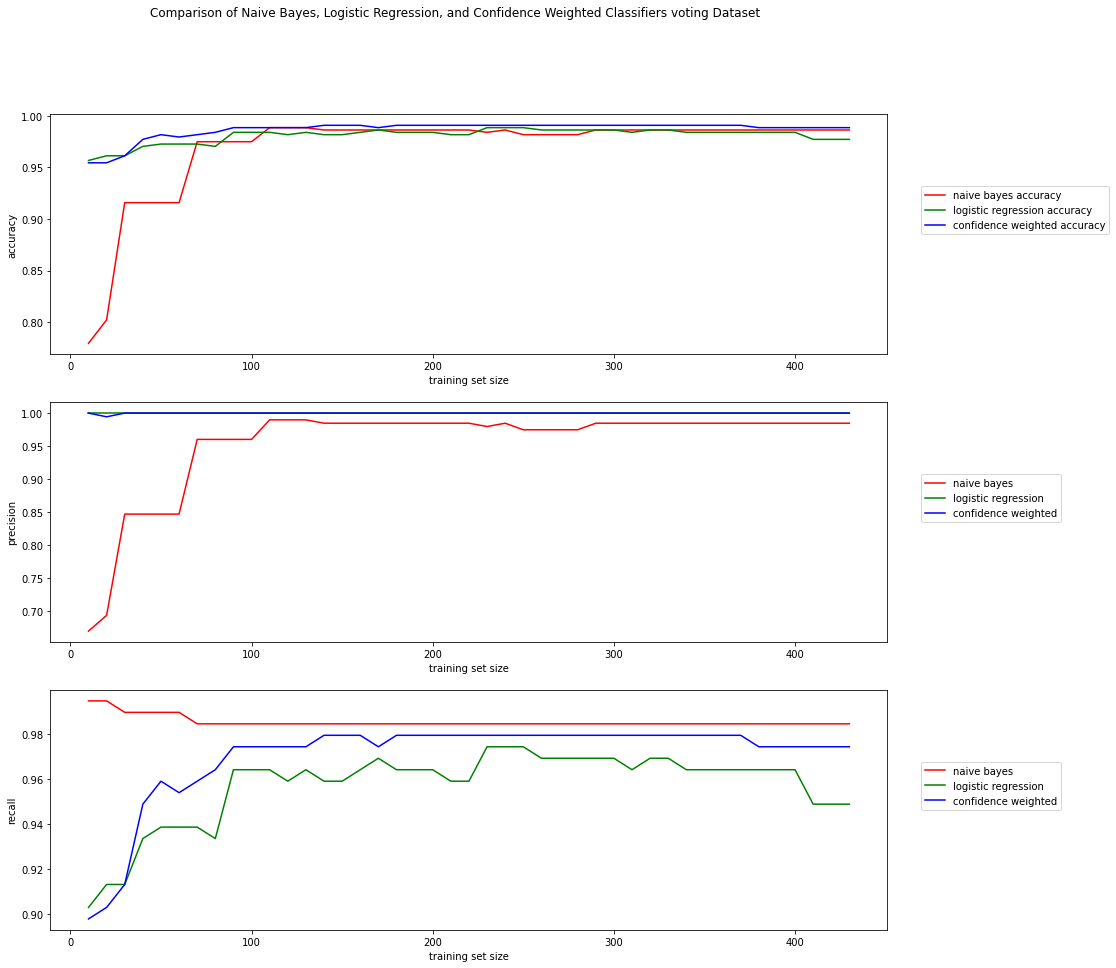

In [107]:
combined_predictions("voting")

In [128]:
combined_predictions("spam")

10
3746
7482
11218
14954
18690
22426
26162
29898
33634


In [ ]:

combined_predictions("volcanoes")

TypeError: 'float' object cannot be interpreted as an integer


# Conclusions

On our datasets, we observed that our classifier did converge to high accuracy values of the linear regression classifier when trained on larger training sets while having a slightly higher accuracy on smalling training sets. This suggests that conditional likelihood estimates of the naive Bayes and logistic regression classifiers may be effective confidence measures when comparing between multiple probabilistic classifiers. Knowing that two classifiers can be combined in this way to improve the performance of the combined classifier, we hypothesize that a similar process could be used with multiple probabilistic classifiers with different models with the combined classifier taking only the highest confidence estimates of each classifier. 